In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy
import os
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.formula.api as smf

# Homework \#4

## Dimensional Fund Advisors, 2002 [HBS 9-203-026].

Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.



## 1 DFA's Strategy

This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

## 1.1 Investment philosophy.
(a) In 100 words or less, describe DFA's belief about how to find premium in the market.
(b) To what degree does their strategy rely on individual equity analysis? Macroeconomic fundamentals? Efficient markets?
(c) Are DFA's funds active or passive?
(d) What do DFA and others mean by a "value" stock? And a "growth" stock?



## 1.2 Challenges for DFA's view.
(a) What challenge did DFA's model see in the 1980's?
(b) And in the 1990's?



## 1.3 The market.
(a) Exhibit 3 has data regarding a universe of 5,020 firms. How many are considered "large cap"? What percent of the market value do they account for?
(b) Exhibit 6 shows that the U.S. value factor (HML) has underperformed the broader U.S. equity market in 1926-2001, including every subsample except 1963-1981. So why should an investor be interested in this value factor?



## 2 The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a "size" and "value" factor. Note that these three factors are already listed as excess returns. ${ }^{1}$
Use the data found in 'dfa_analysis_data.xlsx'.

- FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{m}$. The sheet also contains data on two additional factors, SMB and HML, as well as the risk-free rate. You do not need any of these columns for the homework. Just use the MKT column, which is excess market returns. (So no need to subtract the risk-free rate.)


In [2]:
file_path = r"../data/dfa_analysis_data.xlsx"
dfs_raw = pd.read_excel(file_path, sheet_name=None)
for key in dfs_raw.keys():
    print(f"{key}: {dfs_raw[key].shape}")
    display(dfs_raw[key].head())


# factor_mapping = {tick: name
#                   for tick, name in zip(dfs_raw['descriptions'].iloc[:, 0],
#                                                 dfs_raw['descriptions'].iloc[:, 2])}
# factor_mapping

descriptions: (4, 5)


,Unnamed: 0,Name,Unit,Construction,Description
0,Mkt-RF,Market,Excess Return,Market-cap-weighted,US Equities
1,SMB,Size,Excess Return,Small Minus Big,Long small stocks and short big stocks
2,HML,Value,Excess Return,High Minus Low,Long value (high book-to-market) stocks and sh...
3,RF,Risk-free rate,Total Return,Tbills,NaN


factors: (1178, 5)


,Date,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031


portfolios (total returns): (1178, 26)


,Date,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
0,1926-07-31,0.058248,-0.017006,0.004875,-0.014580,0.020534,0.012077,0.024192,0.004926,-0.026049,...,0.015893,0.015278,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623
1,1926-08-31,-0.020206,-0.080282,0.013796,0.014606,0.083968,0.023618,-0.011849,0.040084,0.005038,...,0.013336,0.038730,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576
2,1926-09-30,-0.048291,-0.026154,-0.043417,-0.032729,0.008649,-0.026540,-0.012618,0.010829,-0.035480,...,0.010923,-0.005250,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284
3,1926-10-31,-0.093729,-0.035519,-0.034948,0.034413,-0.025476,-0.028069,-0.032663,-0.050745,-0.080191,...,-0.033361,-0.026559,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129
4,1926-11-30,0.055888,0.041877,0.024623,-0.044494,0.005362,0.031033,-0.023690,0.030078,0.051546,...,0.034448,0.023887,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636


In [3]:
df_ports = dfs_raw['portfolios (total returns)'].copy().set_index("Date")
df_factors = dfs_raw['factors'].copy().set_index("Date")

annual_factor = 12

print("port date range", min(df_ports.index), "-", max(df_ports.index))
print("factors date range", min(df_ports.index), "-", max(df_ports.index))

port date range 1926-07-31 00:00:00 - 2024-08-31 00:00:00
factors date range 1926-07-31 00:00:00 - 2024-08-31 00:00:00



### 2.1 The Factors. Calculate their univariate performance statistics:

- mean
- volatility
- Sharpe
- $\operatorname{VaR}(.05)$

Report these for the following three subsamples:

- Beginning - 1980
- 1981 - 2001
- 2002 - End


In [4]:

def calc_summary(df, annual_factor=1, mask=None, return_cols=None):
    if mask is not None:
        df = df.loc[mask]

    df_summary = df.apply(lambda x: pd.Series({
        "mean": x.mean() * annual_factor,
        "std": x.std() * np.sqrt(annual_factor),
        "sharpe": x.mean() / x.std() * np.sqrt(annual_factor),
        # "Excess Kurtosis": x.kurtosis() - 3,
        "5% VaR": x.quantile(0.05),
       #  "5% cVaR": x[x <= x.quantile(0.05)].mean(),
    }))

    # # Find max_draw_downs
    # df_aum = (df+1).cumprod()
    # draw_downs = (df_aum.cummax() - df_aum) / df_aum.cummax()
    # df_summary.loc["Max Drawdown"] = draw_downs.max()

    if return_cols:
        df_summary = df_summary[return_cols]
    return df_summary

samples = [df_factors.index,
           df_factors.index.year < 1980,
           (df_factors.index.year >= 1981) & (df_factors.index.year < 2001),
           df_factors.index.year >= 2002]

sample_names = ["All", ":1980", "1981:2000", "2001:"]

for sample_name, sample in zip(sample_names, samples):
    if sample_name == "All": continue
    print(sample_name)

    df_summary = calc_summary(df_factors,
                              annual_factor=annual_factor,
                              mask=sample)
    display(df_summary)


:1980


,Mkt-RF,SMB,HML,RF
mean,0.078862,0.033525,0.054118,0.026245
std,0.205175,0.114766,0.133823,0.006968
sharpe,0.384362,0.292119,0.404397,3.766613
5% VaR,-0.083575,-0.043335,-0.041285,0.000000


1981:2000


,Mkt-RF,SMB,HML,RF
mean,0.087970,-0.010530,0.059085,0.064350
std,0.154092,0.116341,0.106127,0.007722
sharpe,0.570891,-0.090510,0.556740,8.333804
5% VaR,-0.059775,-0.044635,-0.040255,0.002500


2001:


,Mkt-RF,SMB,HML,RF
mean,0.089488,0.011007,0.000538,0.014625
std,0.154644,0.088944,0.107348,0.005029
sharpe,0.578674,0.123757,0.005014,2.908227
5% VaR,-0.078735,-0.039070,-0.041245,0.000000



## 2.2 Based on the factor statistics above, answer the following.
(a) Does each factor have a premium (positive expected excess return) in each subsample?


They are very small premiums, they are all positive except for SMB in the 1981-2001 sample


(b) Does the premium to the size factor get smaller after 1980?


Slightly but its hard to jugde due to the high volatility

(c) Does the premium to the value factor get smaller during the 1990's?



Stays about the same but its hard to judge due to the high volatility

(d) How have the factors performed since the time of the case, (2002-present)?



These factors have not been performing well, they have low expected returns, have large draw downs and bad sharpe ratios.


## 2.3 The factors are constructed in such a way as to reduce correlation between them.

Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? Does it achieve this in each subsample?


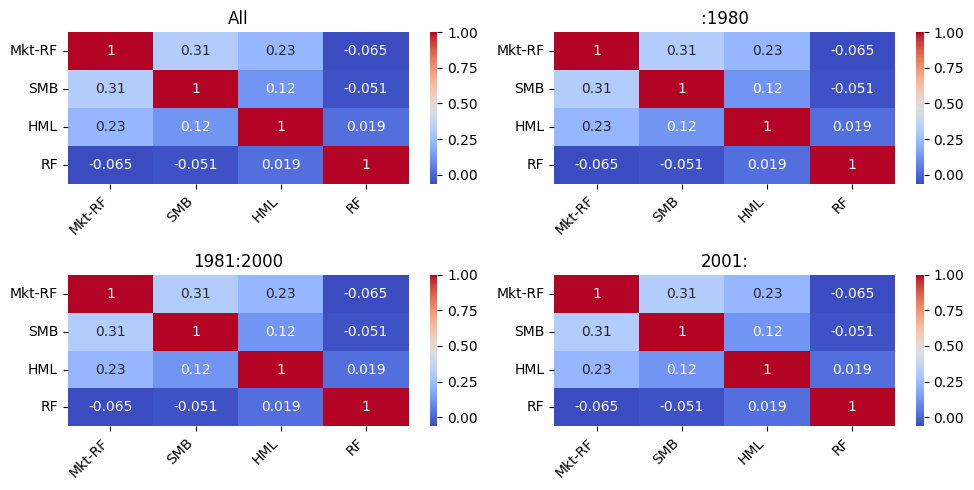

In [5]:
plt.figure(figsize=(10, 5))

i = 0
for sample_name, sample in zip(sample_names, samples):
    plt.subplot(2, 2, i+1)

    df_corr = (df_factors[[c for c in df_factors if "_adj" not in c]]
            # .rename(columns=ticker_mapping)
            .corr()
            )

    # Plot with seaborn
    sns.heatmap(df_corr, annot=True, cmap="coolwarm")
    plt.xticks(rotation=45,ha='right')
    plt.yticks(rotation=0)
    plt.title(f"{sample_name}")
    i+=1
plt.tight_layout()
plt.show()

Yes it achieves these low correlations very well through out each sample and in all the time.



## 2.4. Plot the cumulative returns of the three factors.

Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.



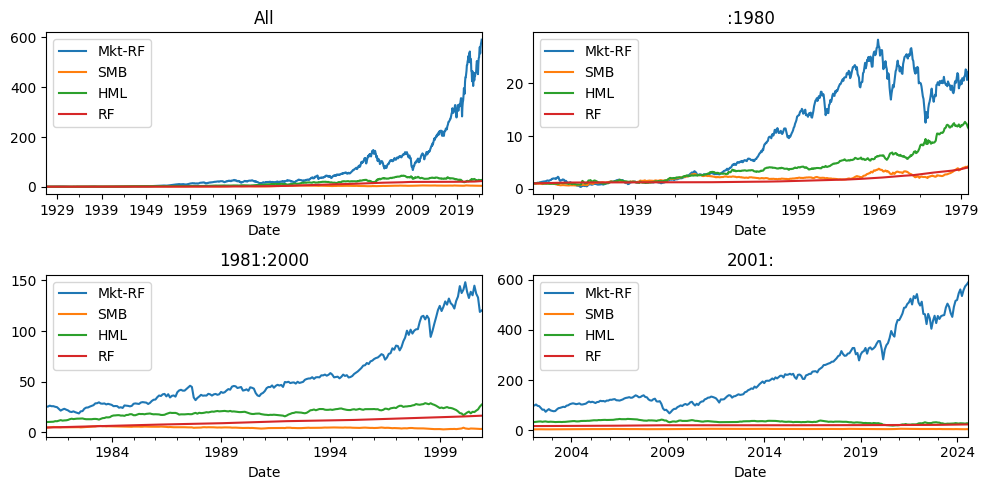

In [6]:
plt.figure(figsize=(10, 5))

i = 0
for sample_name, sample in zip(sample_names, samples):
    plt.subplot(2, 2, i+1)

    # Plot cum returns
    cum_rets = (df_factors+1).cumprod()
    cum_rets = cum_rets.loc[sample]
    cum_rets.plot(ax=plt.gca())
    plt.legend()

    plt.title(f"{sample_name}")
    i+=1
plt.tight_layout()
plt.show()


## 2.5. Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

From 1981 to 2001, we see that although the market risk premium dominates, we see that there is still a significant effect from SMB and HML to a smaller degree. So at this point, I would still say that all 3 factors are significant with a greater weighting on the market.

From 2001 onwards, we see this trend of market risk premium dominating but to a much greater degree. We see that the returns of SMB and HML are barely visible relative to the massive returns of the market. From 2001 onwards, I would not continue to emphasize all 3 factors.

Due to continued growth of the market returns and the stagnant returns of HML and SMB, I would advise DFA to not continue to emphasize all 3 factors.


## 3 CAPM

DFA believes that premia in stocks and stock portfolios is related to the three factors.
Let's test 25 equity portfolios that span a wide range of size and value measures. ${ }^{2}$

- PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for $n=1, \ldots, 25$.
- Note that while the factors were given as excess returns, the portfolios are total returns.
- For this entire problem, focus on the 1981-Present subsample.


In [7]:
df_excess_returns = df_ports.subtract(df_factors["RF"],axis=0)
df_excess_returns = df_excess_returns[df_excess_returns.index.year >= 1981]

display(df_excess_returns.head())

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054941,-0.014888,0.009909,0.005911,0.021085,-0.059733,-0.010738,-0.012684,0.007626,0.020623,...,-0.077022,-0.044926,-0.012942,-0.005534,0.003924,-0.071746,-0.083592,-0.074265,-0.010037,0.009464
1981-02-28,-0.044745,-0.010535,0.001444,0.009240,0.014398,-0.014473,0.005102,0.017420,0.024361,0.027939,...,0.002600,0.014707,0.034695,0.002673,0.027240,0.021950,0.009415,-0.016450,0.020446,-0.016853
1981-03-31,0.060718,0.082395,0.073568,0.077655,0.061040,0.068082,0.071500,0.066319,0.066325,0.063175,...,0.080443,0.055672,0.073222,0.061934,0.064868,0.017353,0.019940,-0.008875,0.022230,0.069573
1981-04-30,0.018141,0.035914,0.024600,0.036523,0.044090,0.006012,0.024744,0.026586,0.026781,0.029442,...,-0.010849,-0.019081,-0.006016,-0.007801,0.006253,-0.038311,-0.053508,-0.038006,0.010439,-0.040374
1981-05-31,0.038153,0.037824,0.032399,0.013389,0.016837,0.050452,0.010304,0.016889,-0.008609,0.013558,...,0.023970,0.010245,0.007640,-0.000759,0.021978,0.004288,-0.032791,-0.031355,0.026669,-0.005979



## 3.1 Summary Statistics. For each portfolio,

- Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- Calculate the (annualized) univariate statistics from 1.1.
- Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their $\operatorname{VaR}(.05)$ statistics?



In [8]:
df_summary = calc_summary(df_excess_returns,
                          annual_factor=annual_factor)
display(df_summary.style.format('{:,.5f}'))

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,ME3 BM1,ME3 BM2,ME3 BM3,ME3 BM4,ME3 BM5,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
mean,0.00667,0.08869,0.09201,0.11600,0.12784,0.05887,0.10052,0.10595,0.10883,0.11599,0.07099,0.10716,0.09234,0.10876,0.12385,0.09236,0.09597,0.09269,0.10169,0.10822,0.09393,0.08524,0.08249,0.07022,0.09929
std,0.27377,0.23640,0.20125,0.19427,0.21004,0.24516,0.20553,0.18578,0.18210,0.21562,0.22483,0.18855,0.17304,0.18087,0.20335,0.20282,0.17787,0.17528,0.17607,0.19879,0.16405,0.15405,0.15311,0.17159,0.20677
sharpe,0.02437,0.37516,0.45717,0.59710,0.60865,0.24012,0.48906,0.57029,0.59767,0.53797,0.31574,0.56835,0.53362,0.60130,0.60906,0.45536,0.53957,0.52879,0.57757,0.54436,0.57261,0.55334,0.53878,0.40926,0.48019
5% VaR,-0.12606,-0.09475,-0.08623,-0.07697,-0.08854,-0.10410,-0.08566,-0.07849,-0.07614,-0.09640,-0.09970,-0.07848,-0.07347,-0.07181,-0.08423,-0.08364,-0.07291,-0.07561,-0.06950,-0.08343,-0.07548,-0.06505,-0.07038,-0.07576,-0.09414


From the plot below there seems to be no apparent pattern in mean vs vol. Meaning there doesn't seem to be a big reward to investing in more volatil stocks.


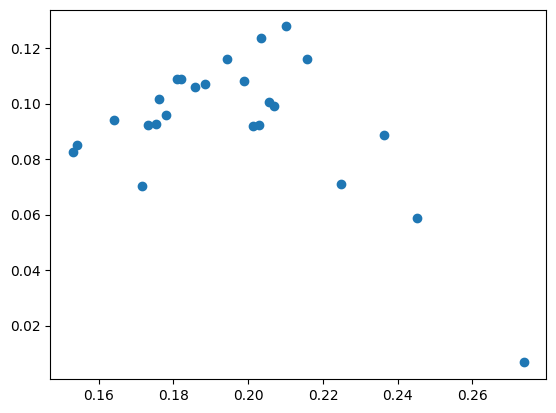

In [9]:
plt.scatter(df_summary.loc["std"], df_summary.loc["mean"])

## 3.2 CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)

Specifically, it asserts that, for any excess return, $\widetilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

$$
\begin{equation*}
\mathbb{E}\left[\tilde{r}_{t}^{i}\right]=\beta^{i, m} \mathbb{E}\left[\tilde{r}_{t}^{m}\right] \tag{CAPM}
\end{equation*}
$$

Let's examine whether that seems plausible.




(a) For each of the $n=25$ test portfolios, run the CAPM time-series regression:

$$
\tilde{r}_{t}^{i}=\alpha^{i}+\beta^{i, m} \tilde{r}_{t}^{m}+\epsilon_{t}^{i}
$$

So you are running 25 separate regressions, each using the $T$-sized sample of time-series data.
Report the betas and alphas for each test asset.


In [10]:
def factor_model(df, y_var, x_vars, intercept=True):
    if not isinstance(x_vars, list):
        x_vars = [x_vars]
    # Run regression
    formula = f"{y_var} ~ {' + '.join(x_vars)}"
    if not intercept:
        formula = formula + " - 1"
    model = smf.ols(formula=formula, data=df)
    results = model.fit()
    summary = results.summary()

    return model, results

def risk_summary(df, market_col, index_cols=None, annual_scale=12):
    if index_cols is None:
        index_cols = list(df.columns)
        if market_col in index_cols: index_cols.remove(market_col)


    data = []
    for c in index_cols:
        _, results = factor_model(df, c, market_col)
        market_beta = results.params[market_col]

        mu_return = df[c].mean() * annual_scale
        vol_return = df[c].std() * np.sqrt(annual_scale)

        data.append({
            "index": c,
            "market_alpha": results.params["Intercept"],
            "market_beta": market_beta,
            "trenor_ratio": mu_return / market_beta,
            "info_ratio": mu_return / vol_return,
        })
    return pd.DataFrame(data).set_index("index")

market_col = "Mkt-RF"
df_reg = pd.merge(df_excess_returns,
                  df_factors[[market_col]],
                  how="left",
                  left_index=True,
                  right_index=True)

# Cleam cols
df_reg.columns = [c.replace(" ", "_").replace("-", "_") for c in df_reg.columns]
market_col = market_col.replace(" ", "_").replace("-", "_")


df_capm = risk_summary(df_reg, market_col)
display(df_capm)

,market_alpha,market_beta,trenor_ratio,info_ratio
index,,,,
SMALL_LoBM,-0.008894,1.356365,0.004918,0.024366
ME1_BM2,-0.000731,1.165744,0.076080,0.375163
ME1_BM3,0.000385,1.045218,0.088026,0.457170
ME1_BM4,0.002891,0.972450,0.119285,0.597099
SMALL_HiBM,0.003721,0.994979,0.128483,0.608646
ME2_BM1,-0.004421,1.338627,0.043976,0.240125
ME2_BM2,0.000469,1.134902,0.088568,0.489059
ME2_BM3,0.001662,1.028607,0.103000,0.570288
ME2_BM4,0.002279,0.974696,0.111660,0.597670



(b) Report the mean-absolute-error of the CAPM:

$$
\mathrm{MAE}=\frac{1}{n} \sum_{i=1}^{n}\left|\alpha_{i}\right|
$$

If the CAPM were true, what would we expect of the MAE?


In [11]:
df_capm["market_alpha"].abs().mean()

0.0018690022417311466

We would expect this to be about 0. This is close to enough to 0 so this makes sense.


[^1](c) Report the estimated $\beta^{i, m}$, Treynor Ratio, $\alpha^{i}$, and Information Ratio for each of the $n$ regressions.
(d) If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?


If CAPM model was true we would have alphas, information ratios, and treynor ratios of about 0.


## 3.3 Cross-sectional Estimation

Let's test (CAPM) directly. We already have what we need:

- The dependent variable, (y): mean excess returns from each of the $n=25$ portfolios.
- The regressor, (x): the market beta from each of the $n=25$ time-series regressions.

Then we can estimate the following equation:

$$
\underbrace{\mathbb{E}\left[\tilde{r}^{i}\right]}_{n \times 1 \text { data }}=\underbrace{\eta}_{\text {regression intercept }}+\underbrace{\beta^{i, m} ;}_{n \times 1 \text { data }} \underbrace{\lambda_{m}}_{\text {regression estimate }}+\underbrace{v}_{n \times 1 \text { residuals }}
$$

- Note that we use sample means as estimates of $\mathbb{E}\left[\tilde{r}^{i}\right]$.
- This is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- This is a single regression, where we are combining evidence across all $n=25$ series. Thus, it is a cross-sectional regression!
- The notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.
(a) Report the R-squared of this regression.
(b) Report the intercept, $\eta$.
(c) Report the regression coefficient, $\lambda_{m}$.


In [12]:
df_cross = pd.DataFrame()
df_cross["mean_return"] = df_excess_returns.mean(axis=0)
df_cross.index = [c.replace(" ", "_").replace("-", "_") for c in df_cross.index]

df_cross = pd.merge(df_cross,
                    df_capm[["market_beta"]],
                    how="left",
                    left_index=True,
                    right_index=True)
# display(df_cross.head())

In [13]:
formula = f"mean_return ~ market_beta"
model = smf.ols(formula=formula, data=df_cross)
results = model.fit()
summary = results.summary()

print(f"R-squared:", results.rsquared)
print(f"Intercept:", results.params["Intercept"])
print(f"regression coefficient:", results.params["market_beta"])

R-squared: 0.3005567883855057
Intercept: 0.017385218939714203
regression coefficient: -0.009015397451430273



What would these three statistics be if (CAPM) were true?



If the CAPM model was true, we would have a intercept around 0 and it would have a R-squared close to 0 (Really good fit). You should not be able to tell what the betas would be because the correlation to the markets would differ between portfolios.



## 3.4 Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?


The regression from above is not good, indicated by the low R-Squared. Also there is a large intercept which means there is a lot of return not explained by the market. So DFA may be right, there is likely other factors that can explain these risk premia.


## 4 Extensions

## 4.1 Re-do the analysis of 3.3 and 3.3 , but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the $n=25$ portfolios.
You will not use the factor data for this problem!

- Calculate $\tilde{r}^{\text {tan }}$ by solving the MV optimization of the $n$ excess returns.
- Consider this to be your single factor.

Instead of testing (CAPM), you will test the MV model:

$$
\begin{equation*}
\mathbb{E}\left[\tilde{r}_{t}^{i}\right]=\beta^{i, \text { tan }} \mathbb{E}\left[\tilde{r}_{t}^{\text {tan }}\right] \tag{MV}
\end{equation*}
$$

What do you find?



In [14]:
def tangent_portfolio(df_returns, flip_weights=False, annual_factor=12):
    def compute_stats(weights, mu_hat, sigma_hat, annual_factor=12):
        p_return = weights.T @ mu_hat * annual_factor
        p_vol = np.sqrt(weights.T @ sigma_hat @ weights) * np.sqrt(annual_factor)
        return p_vol, p_return
    
    mu_hat = df_returns.mean().values
    sigma_hat = df_returns.cov().values
    
    sigma_inv = np.linalg.inv(sigma_hat)
    weights = sigma_inv @ mu_hat
    weights = weights / np.sum(weights)
    
    t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    if t_return < 0 and flip_weights:
        weights *= -1
        t_vol, t_return = compute_stats(weights, mu_hat, sigma_hat, annual_factor=annual_factor)
    return [t_vol, t_return, weights]

def run_capm_type_model(df_returns, df_factors, display_info=True, annual_scale=1):
    # merge data
    df_reg = pd.merge(df_returns,
                      df_factors,
                        how="left",
                        left_index=True,
                        right_index=True)
    # Clean cols
    col_mapping = {c: c.replace(" ", "_").replace("-", "_") for c in df_reg.columns}
    rev_mapping = {v: k for k, v in col_mapping.items()}
    df_reg.rename(columns=col_mapping, inplace=True)
    factor_cols = [col_mapping[c] for c in df_factors.columns]
    return_cols = [col_mapping[c] for c in df_returns.columns]
    
    # Run Regressions
    data = []
    for c in return_cols:
        _, results = factor_model(df_reg, c, factor_cols)

        mu_return = df_reg[c].mean() * annual_scale
        vol_return = df_reg[c].std() * np.sqrt(annual_scale)

        row_data = {
            "index": c,
            "info_ratio": mu_return / vol_return,
        }
        
        for k, v in results.params.items():
            if k == "Intercept":
                row_data[f"{k}"] = v
            else:
                row_data[f"{k}_beta"] = v
        data.append(row_data)
        
    
    df_regressions_info = pd.DataFrame(data).set_index("index")
    
    # Cross regression
    df_cross = pd.DataFrame()
    df_cross["mean_return"] = df_returns.mean(axis=0)
    df_cross.index = [c.replace(" ", "_").replace("-", "_") for c in df_cross.index]
    cross_factor_cols = [c for c in df_regressions_info if "_beta" in c]
    df_cross = pd.merge(df_cross,
                        df_regressions_info,
                        how="left",
                        left_index=True,
                        right_index=True)
    _, results = factor_model(df_cross, "mean_return", cross_factor_cols)
    cross_reg_info = {
        "R-squared": results.rsquared,
    }
    cross_reg_info.update({k: v for k, v in results.params.items()})
    
    if display_info:
        display(df_regressions_info)

        for k, v in cross_reg_info.items():
            print(f"{k}: {v:.4f}")
        
    return df_regressions_info, cross_reg_info, 

# Get tangent portfolio
_, _, t_weights = tangent_portfolio(df_excess_returns) 
df_factors["tangent"] = df_excess_returns @ t_weights

_, _ = run_capm_type_model(df_excess_returns, df_factors[["tangent"]])

,info_ratio,Intercept,tangent_beta
index,,,
SMALL_LoBM,0.007034,1.379105e-16,0.017416
ME1_BM2,0.108300,1.118897e-16,0.231549
ME1_BM3,0.131974,7.068998e-17,0.240209
ME1_BM4,0.172368,9.996344e-17,0.302847
SMALL_HiBM,0.175701,5.637851e-17,0.333758
ME2_BM1,0.069318,1.216475e-16,0.153692
ME2_BM2,0.141179,4.662069e-17,0.262425
ME2_BM3,0.164628,3.220080e-17,0.276604
ME2_BM4,0.172532,2.547875e-17,0.284144


R-squared: 1.0000
Intercept: 0.0000
tangent_beta: 0.0319


The alphas from this regression are much smaller. They are all 0. The R-Squared is also 1.


2. Re-do the analysis of 3.3 and 3.3 , but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

$$
\begin{equation*}
\mathbb{E}\left[\tilde{r}_{t}^{i}\right]=\beta^{i, m} \mathbb{E}\left[\tilde{r}_{t}^{m}\right]+\beta^{i, s} \mathbb{E}\left[\tilde{r}_{t}^{s}\right]+\beta^{i, v} \mathbb{E}\left[\tilde{r}_{t}^{v}\right] \tag{FF3}
\end{equation*}
$$


In [15]:
df_fama_french, _ = run_capm_type_model(df_excess_returns, df_factors[["Mkt-RF", "SMB", "HML"]])

,info_ratio,Intercept,Mkt_RF_beta,SMB_beta,HML_beta
index,,,,,
SMALL_LoBM,0.007034,-0.007151,1.111846,1.392517,-0.253788
ME1_BM2,0.108300,0.000120,0.965456,1.317675,-0.014432
ME1_BM3,0.131974,0.000050,0.923142,1.065113,0.277445
ME1_BM4,0.172368,0.001849,0.877818,1.065753,0.477399
SMALL_HiBM,0.175701,0.001921,0.929787,1.066006,0.691417
ME2_BM1,0.069318,-0.002702,1.141897,1.023281,-0.310250
ME2_BM2,0.141179,0.000596,1.013778,0.915858,0.121287
ME2_BM3,0.164628,0.000721,0.973977,0.719244,0.389224
ME2_BM4,0.172532,0.000698,0.941288,0.748332,0.575080


R-squared: 0.4628
Intercept: 0.0155
Mkt_RF_beta: -0.0083
SMB_beta: -0.0002
HML_beta: 0.0029



3. We measured how well the CAPM performs by checking the MAE of the time-series alphas.

Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

$$
H=T\left[1+\left(\mathrm{SR}_{m}\right)^{2}\right]^{-1} \boldsymbol{\alpha}^{\prime} \boldsymbol{\Sigma}_{\epsilon}^{-1} \boldsymbol{\alpha} \sim \chi_{n}^{2}
$$

Note the following:

- $\boldsymbol{\alpha}$ is an $n \times 1$ vector of the individual regression alphas, $\alpha^{i}$.
- $\boldsymbol{\Sigma}_{\epsilon}$ is the $n \times n$ covariance matrix of the time-series of regression residuals, $\epsilon^{i}$, corresponding to each regression.
- $\mathrm{SR}_{m}$ is the Sharpe-Ratio of $\tilde{r}^{m}$.

The test statistic, $H$, has a chi-squared distribution with $n=25$ degrees of freedom. So under the null hypothesis of the CAPM holding, $H$ should be small, and the distribution allows us to calculate the probability of seeing such a large $H$, conditional on the CAPM being true.

(a) Which is a stricter test: checking whether any of the $n$ values of $\alpha^{i}$ have a statistically significant t-test or checking whether $H$ calculated above is significant?

In [16]:
mask = df_factors.index.year >= 1981
SR = df_factors.loc[mask, 'Mkt-RF'].mean() *12/ df_factors.loc[mask, 'Mkt-RF'].std()*np.sqrt(12)
Sigma = 1 # todo cov of residuals
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = df_fama_french['Intercept']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

The H test is stricter because it tests all of the columns together. todo

(todo ta) By definition, a joint test is stricter than testing the conditions individually.
In our case, we can see that most of the alphas (20 alphas) are not significant (as -value 0.05) while 5 alphas are signficant (as -value 0.05) as judged by their individual -stats, yet all of them are jointly significant as judged by this joint test.




(b) Conceptually, how does the test-statistic $H$ relate to checking whether $\tilde{r}^{m}$ spans the tangency portfolio?


[^0]:    ${ }^{1}$ The column header of the "Market" factor makes this obvious, but it is less obvious-though still true-for the other two factors.

[^1]:    ${ }^{2}$ Do not worry about the specific construction of these portfolios for now. We will discuss it further.



The two tests are very similar. todo

(todo ta) We have demonstrated that an LFM is exactly the same as asserting that a set of factors spans the MV frontier, (and thus spans the tangency portfolio.)
Thus, this test can be interpreted as checking whether investing in the alphas gets beyond the tangency portfolio. The test stat is basically comparing the square SR of the alphas to the square SR of the factors.

